**Only work with tiff images for now !**

This notebook will allow user to plot over a range of images a given profile

## 1. Prepare logbook 

In [2]:
from IPython.html import widgets
from IPython.display import display
from IPython.html.widgets import interact

In [3]:
import os, os.path

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [46]:
from PIL import Image
import numpy as np

## 2. Select input folder 

In [6]:
from PyQt4 import QtGui
%gui qt

In [7]:
try:
    from PySide import QtCore, QtGui
except ImportError:
    from PyQt4 import QtCore, QtGui

def gui_fname(dir=None):
    """Select a directory
    """
    if dir is None: dir ='./'
    dir_name = QtGui.QFileDialog.getExistingDirectory(None, "Select Folder ...",
                                                  dir,
                                                  QtGui.QFileDialog.ShowDirsOnly)
    return dir_name

In [8]:
%gui qt
data_folder = gui_fname()

## 3. Load the data 

In [10]:
class ListOfFilesHandler(object):
    
    list_files = None
    number_files = -1
    
    def __init__(self, folder = None):
        self.folder = folder
        
        self.get_list_files()
        self.get_number_files()
        
    def get_list_files(self):
        self.list_files = [name for name in os.listdir(self.folder) \
                           if os.path.isfile(os.path.join(self.folder, name))]
        
    def get_number_files(self):
        self.number_files = len(self.list_files)


In [12]:
o_list_files = ListOfFilesHandler(folder = data_folder)

In [15]:
list_files = o_list_files.list_files

In [17]:
#from pprint import pprint
#pprint(list_files)

In [47]:
w = widgets.IntProgress()
w.max = 100
display(w)
index = 0

array_images = []
for file in list_files:
    
    _full_file = os.path.join(data_folder, file)
    _image = np.asarray(Image.open(_full_file))
    array_images.append(_image)
    w.value = index
    index += 1

## 4. Select Profile Region 

In [48]:
[image_height, image_width] = array_images[0].shape

[66, 123, 33, 61, <matplotlib.figure.Figure at 0x11ac32390>]

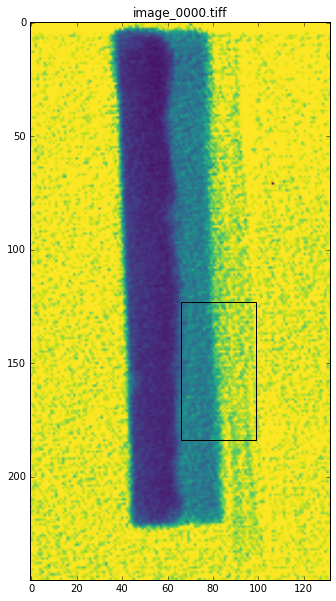

In [95]:
def plot_images_with_box(file_index, x_left, y_top, width, height):
    
    data = array_images[file_index][:, :]
    
    fig_box = plt.figure(figsize=(10, 10))
    ax_img = plt.subplot(111)
    
    ax_img.imshow(data, cmap='viridis')
    ax_img.set_title(list_files[file_index])
    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))
    
    return [x_left, y_top, width, height, fig_box]

number_of_files = len(list_files)
profile = interact(plot_images_with_box,
                  file_index = widgets.IntSlider( min=0, max=number_of_files, value=0, step=1, description='Image index'),
                  x_left = widgets.IntSlider( min=0, max=image_width-1, step=1, value=int(image_width/2)),
                  y_top = widgets.IntSlider( min=0, max=image_height-1, step=1, value=int(image_height/2)),
                  width = widgets.IntSlider( min=0, max=image_width-1, step=1, value=int(image_width/4)),
                  height = widgets.IntSlider( min=0, max=image_height-1, step=1, value=int(image_height/4)))
    

In [99]:
[_, _, _, _, fig_box] = profile.widget.result

## 5. calculate profile over range of images 

In [96]:
print(profile.widget.kwargs)
y_top = profile.widget.kwargs['y_top']
x_left = profile.widget.kwargs['x_left']
width = profile.widget.kwargs['width']
height = profile.widget.kwargs['height']

{'y_top': 123, 'width': 33, 'file_index': 0, 'height': 61, 'x_left': 66}


In [86]:
w = widgets.IntProgress()
w.max = 100
display(w)
index = 0

profile_array = []
for _image in array_images:
    _profile_image = _image[y_top:y_top+height, x_left:x_left+width]
    _value = np.sum(_profile_image)
    profile_array.append(_value)
    w.value = index
    index += 1

## 6. Display profile 

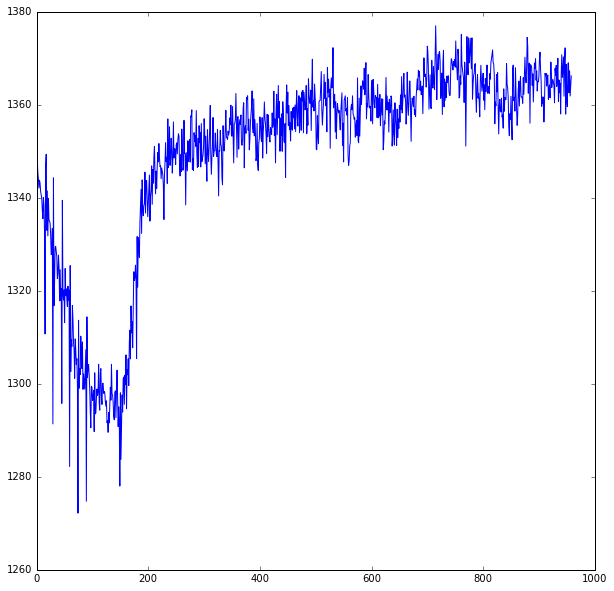

In [89]:
fig_profile = plt.figure(figsize=(10, 10))
plt.plot(profile_array)           

In [81]:
image_0 = array_images[0]

In [82]:
image_0.shape

(246, 132)

In [85]:
np.sum(image_0)

25064.322

## 7. Export report 

Select output folder

In [112]:
%gui qt
output_folder = gui_fname(dir = data_folder)

record the figure selection plot

In [116]:
step = 50 # jump by 50 files

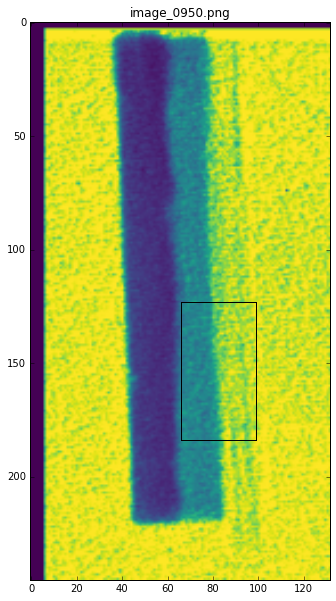

In [119]:
w = widgets.IntProgress()
w.max = int(number_of_files/50)
display(w)
index = 0

fig_box = plt.figure(figsize=(10, 10))
ax_img = plt.subplot(111)

counter = 0
for index in range(0, number_of_files, step):
    
    _image = array_images[index]
    _file = list_files[index].split(".")
    _file = ".".join([_file[0], "png"])
    _output_file = os.path.join(output_folder, _file)
    
    
    ax_img.imshow(_image, cmap='viridis')
    ax_img.set_title(_file)
    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))

    fig_box.savefig(_output_file)
    w.value = counter
    counter += 1


record the figure of the profile

In [120]:
_profile_file = os.path.join(output_folder, "profile_2d.png")
fig_profile.savefig(_profile_file)

record the data into txt file

In [137]:
_data_file = os.path.join(output_folder, "data_profile.txt")
f = open(_data_file, "w")

In [138]:
data = []
data.append("# y_top: %i\n" % y_top)
data.append("# x_left: %i\n" % x_left)
data.append("# width: %i\n" % width)
data.append("# height: %i\n" % height)

In [139]:
data.append("\n")
data.append("#index sum_counts\n")
for index, value in enumerate(profile_array):
    data.append("%i %i\n" %(index, value))

In [140]:
f.writelines(data)
f.close()